In [233]:
# Import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import speech_recognition as sr
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

In [234]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hanif_i3hvqmi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hanif_i3hvqmi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hanif_i3hvqmi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [235]:
# Importing the dataset
with open('dataset.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [236]:
data.head() # Cetak data baris pertama sampai baris kelima

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,,tidak ada tanggapan


In [237]:
data.tail() # Cetak data baris ke-70 sampai baris akhir

,patterns,tags
282,Bagaimana saya tahu jika saya tidak sehat?,fakta-29
283,Bagaimana saya bisa menjaga hubungan sosial? B...,fakta-30
284,Apa perbedaan antara kecemasan dan stres?,fakta-31
285,Apa perbedaan antara kesedihan dan depresi?,fakta-32
286,Perbedaan antara kesedihan dan depresi,fakta-32


In [238]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))
data

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,,tidak ada tanggapan
...,...,...
282,bagaimana saya tahu jika saya tidak sehat,fakta-29
283,bagaimana saya bisa menjaga hubungan sosial ba...,fakta-30
284,apa perbedaan antara kecemasan dan stres,fakta-31
285,apa perbedaan antara kesedihan dan depresi,fakta-32


In [239]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

350 unique lemmatized words [',', '.', '3', 'ada', 'adalah', 'adikku', 'akal', 'akan', 'akhir-akhir', 'akibat', 'aku', 'alami', 'anak', 'anda', 'antara', 'apa', 'apa-apa', 'apakah', 'artinya', 'atau', 'aturan', 'ayah', 'bagaimana', 'bagi', 'bagiku', 'bagus', 'bahagia', 'baik', 'baik-baik', 'bantu', 'bantuan', 'banyak', 'baru', 'beberapa', 'belajar', 'belum', 'benar', 'benci', 'berapa', 'berbeda', 'berbuat', 'berguna', 'berharap', 'berharga', 'berhasil', 'berhenti', 'berlatih', 'berlebihan', 'berpikir', 'bertahan', 'biasa', 'bicara', 'biologis', 'bisa', 'bisakah', 'bodoh', 'bolehkah', 'bullying', 'bunuh', 'buruk', 'butuh', 'bye', 'cara', 'caranya', 'cemas', 'ceritakan', 'ciri', 'ciri-ciri', 'contoh', 'cou', 'cukup', 'dalam', 'dampak', 'dan', 'dapat', 'darah', 'dari', 'definisikan', 'dekat', 'dengan', 'depresi', 'di', 'diabetes', 'diam', 'dikatakan', 'dilakukan', 'dimaksud', 'diri', 'diriku', 'do', 'dukung', 'dukungan', 'dunia', 'efek', 'fakta', 'fisik', 'fokus', 'gagal', 'gangguan', 'ga

In [240]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

138 classes ['Aku membenci diriku sendiri!', 'Aku mengecewakan semuanya', 'Aku sedih', 'Apa aturan 3 3 3 untuk kecemasan?', 'Apa penyebab biologis depresi?', 'Apa penyebab depresi?', 'Apa penyebab utama depresi?', 'Apa saja jenis depresi?', 'Apa saja tahapan kecemasan?', 'Apa yang dimaksud dengan kecemasan dan depresi?', 'Apakah depresi merupakan efek samping dari diabetes?', 'Apakah kita mengendalikan pikiran kita?', 'Apakah sekolah merupakan penyebab depresi?', 'Apakah tidur berlebihan menyebabkan depresi?', 'Bagaimana depresi mempengaruhi dunia?', 'Bagaimana kita bisa mengurangi kecemasan?', 'Bahagia', 'Berapa banyak pikiran sehari yang kita miliki?', 'Berapa lama kecemasan bisa bertahan?', 'Berharga', 'Bisakah gula darah rendah menyebabkan pikiran untuk bunuh diri?', 'Bisakah kurang tidur membuat Anda merasa sedih?', 'Bodoh', 'Cara_menjaga_kesehatan_mental', 'Ciri_stress', 'Default', 'Fakta-1', 'Kasual', 'Kelompok usia mana yang memiliki tingkat depresi tertinggi?', 'Lelucon', 'Mam

In [241]:
# documents = combination between patterns and intents
print (len(documents), "documents")

1043 documents


In [242]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])

In [243]:
# Apply padding
x_train = pad_sequences(train)

# Encoding the outputs
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [244]:
print(x_train) # Padding Sequences

[[  0   0   0 ...   0   0 171]
 [  0   0   0 ...   0   0 172]
 [  0   0   0 ...   0   0 173]
 ...
 [  0   0   0 ...  16  34  26]
 [  0   0   0 ... 170  34   7]
 [  0   0   0 ... 170  34   7]]


In [245]:
print(y_train) #Label Encodings

[109 109 109 109 134 128 112  35  35  35 108 108 108 108 108 108 108 108
 108 133 133 133 133 133 126 137  23  30 110 110 110 110 127  24  76 116
  64 123 125  75 107 118 124  57   7  45  56  50  54   5   6  28  37  36
  12   4  14  41   9  13  21  10  20  18   8  38  34   3  11  17  15  53
  69  58  44  48   0  47  46  59  51  60  62   2  43  61  49  52   1  63
  71  55  70  70  70  70  70  70  70  65  65  65  65  65  65  65  65  33
  33  33  33  33  19  19  19  19  19 114 114 114 114  16  16  16  16  16
  16  16  27  27  27  27  27  27  27  27  27  27  27 131 131 135 135 135
 135 136 136 136 136 136 136 111 111 111 111 113 113 113 113 113 113 119
 119 119 119 119 119  74  74  74  74  74 117 117 117  73  73  73  25  25
  25  25  25  25  25  25  29  29 120 120 120 129 129 129 129  29  29 120
 120 120 129 129 129 129  22  22  22  22 132 132 132 130 130 130 130  68
 122 115 115  67  67  67  40  40  40  66  66  31  31  32  32  39  42  42
  42  72  72  72 121 121  26  26  87  87  98  98 10

In [246]:
# input length
input_shape = x_train.shape[1]
print(input_shape)

18


In [247]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [248]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  347
output length:  138


In [249]:
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))

In [250]:
pickle.dump(le, open('labelencoder.pkl','wb'))
pickle.dump(tokenizer, open('tokenizer.pkl','wb'))

In [251]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i) # Layer Embedding
x = LSTM(10, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x)

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [252]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='/content/drive/MyDrive/Chatbot/model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [253]:
model.summary() # Menampilkan Parameter Model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 18)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 18, 10)            3480      
                                                                 
 lstm_1 (LSTM)               (None, 18, 10)            840       
                                                                 
 flatten_1 (Flatten)         (None, 180)               0         
                                                                 
 dense_1 (Dense)             (None, 138)               24978     
                                                                 
Total params: 29298 (114.45 KB)
Trainable params: 29298 (114.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [254]:
# Training the model (Latih Model Data)
train = model.fit(x_train, y_train, epochs=400)

Epoch 1/400
9/9 [==============================] - 2s 6ms/step - loss: 4.9256 - accuracy: 0.0139
Epoch 2/400
9/9 [==============================] - 0s 6ms/step - loss: 4.9063 - accuracy: 0.0174
Epoch 3/400
9/9 [==============================] - 0s 7ms/step - loss: 4.8753 - accuracy: 0.0418
Epoch 4/400
9/9 [==============================] - 0s 7ms/step - loss: 4.8160 - accuracy: 0.0383
Epoch 5/400
9/9 [==============================] - 0s 6ms/step - loss: 4.7183 - accuracy: 0.0383
Epoch 6/400
9/9 [==============================] - 0s 5ms/step - loss: 4.6149 - accuracy: 0.0383
Epoch 7/400
9/9 [==============================] - 0s 6ms/step - loss: 4.5870 - accuracy: 0.0383
Epoch 8/400
9/9 [==============================] - 0s 6ms/step - loss: 4.5650 - accuracy: 0.0383
Epoch 9/400
9/9 [==============================] - 0s 6ms/step - loss: 4.5496 - accuracy: 0.0383
Epoch 10/400
9/9 [==============================] - 0s 5ms/step - loss: 4.5297 - accuracy: 0.0383
Epoch 11/400
9/9 [===========

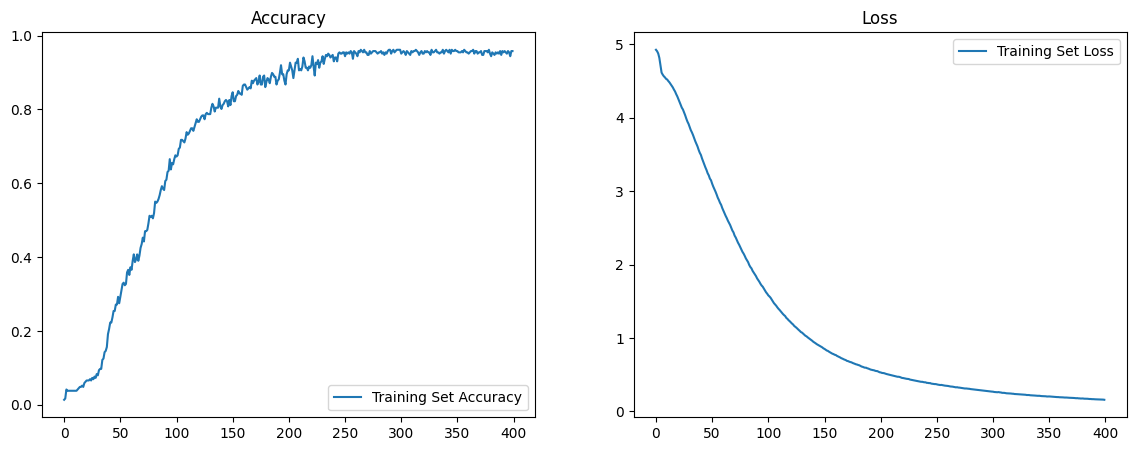

In [255]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [257]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('Kamu : ')

  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model
  output = model.predict(prediction_input)
  output = output.argmax()

# # Menemukan respon sesuai data tag dan memainkan voice bot
  response_tag = le.inverse_transform([output])[0]
  print("Hexabot : ", random.choice(responses[response_tag]))
  # tts = gTTS(random.choice(responses[response_tag]), lang='id')
  # tts.save('/content/drive/MyDrive/Proyek/Natural Language Processing/Chatbot/Model/Hexabot.wav')
  # time.sleep(0.08)
  # ipd.display(ipd.Audio('/content/drive/MyDrive/Chatbot/Model/dataset.wav', autoplay=True))
  print("="*60 + "\n")
  if response_tag == "goodbye":
    break

1/1 [==============================] - 0s 20ms/step
Hexabot :  Hai! Mental illnes di sini. Mau tau informasi tentang apa nih?

1/1 [==============================] - 0s 18ms/step
Hexabot :  Saya mendengarkan. Ceritakan lebih banyak.

1/1 [==============================] - 0s 20ms/step
Hexabot :  Oh oke. Mengapa Anda tidak memberi tahu saya lebih banyak tentang itu?

1/1 [==============================] - 0s 20ms/step
Hexabot :  Oh oke. Mengapa Anda tidak memberi tahu saya lebih banyak tentang itu?



KeyboardInterrupt: Interrupted by user

In [ ]:
model.save('chat_model.h5')

print('Model Created Successfully!')

Model Created Successfully!


c:\Users\hanif_i3hvqmi\OneDrive\Dokumen\chatbot-illness\my-venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
